In [2]:
G_path = '/Users/sepehrbe/My_Drive/DataSources/SkinCare'

In [3]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
#import torchvision.transforms.Compose
import numpy as np
from CNN_NETs import CNN_Nets 
from Net8 import Net8_a
from Model_Training import Model_Training_with_loader
import matplotlib.pyplot as plt
from torch.utils.data import random_split
from torch.utils.data import SubsetRandomSampler
import time
import os
from statistics import mean
import pandas as pd
import sklearn as sk
import pickle
from sklearn.model_selection import train_test_split
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
from sklearn.utils import resample
import warnings
warnings.filterwarnings('ignore')
device = torch.device('cpu')

In [4]:
def confusion_matrix(Y,Y_pred):
    CM = sk.metrics.confusion_matrix(Y,Y_pred)
    print('Nr. of Data : \n', CM.sum())
    print('Accuracy of The Model : \n', np.diag(CM).sum()/CM.sum())
    sk.metrics.ConfusionMatrixDisplay(CM).plot()
    FP = CM.sum(axis=0) - np.diag(CM) 
    FN = CM.sum(axis=1) - np.diag(CM)
    TP = np.diag(CM)
    TN = CM.sum() - (FP + FN + TP)
    weights = CM.sum(axis=1) / CM.sum() 
    ACC = np.nan_to_num((TP+TN)/(TP+FP+FN+TN) , nan=0)
    Recall_Sensitivity = np.nan_to_num(TP/(TP+FN) , nan=0)
    Specificity = np.nan_to_num(TN/(TN+FP) , nan=0)
    Precision = np.nan_to_num(TP/(TP+FP) , nan=0)
    f1_score = np.nan_to_num( 2*Precision*Recall_Sensitivity / (Recall_Sensitivity + Precision), nan=0)
    Performance_DF = pd.concat([pd.DataFrame(CM),pd.DataFrame(weights, columns=['weights']),pd.DataFrame(Precision, columns=['Precision']),pd.DataFrame(Recall_Sensitivity,columns=['Recall_Sensitivity'])
        ,pd.DataFrame(Specificity, columns=['Specificity']),pd.DataFrame(f1_score, columns=['f1_score'])], axis=1)
    total_row1 = pd.Series({'Precision':mean(Precision),'Recall_Sensitivity':mean(Recall_Sensitivity),'Specificity':mean(Specificity),'f1_score':mean(f1_score)}, name='Simple Avg.')
    total_row2 = pd.Series({'Precision':sum(weights*Precision),'Recall_Sensitivity':sum(weights*Recall_Sensitivity),'Specificity':sum(weights*Specificity),'f1_score':sum(weights*f1_score)}, name='Weighted Avg.')
    Performance_DF = Performance_DF.append([total_row1,total_row2])
    cols = ['weights','Precision','Recall_Sensitivity','Specificity','f1_score']
    per_details = Performance_DF[cols].style.format({'weights': "{:.1%}",'Precision': "{:.1%}",'Recall_Sensitivity': "{:.1%}",'Specificity': "{:.1%}",'f1_score': "{:.1%}"})
    return per_details

def plot_loss_accuracy(model_):
    epochs_X = [i for i in range(1, model_.epochs+1)]
    fig, axs = plt.subplots(1,2,figsize=(14,4))
    axs[0].plot(epochs_X , model_.Epochs_Train_loss , 'bo-', label='Train loss')
    axs[0].plot(epochs_X , model_.Epochs_Val_loss,'ro-', label='Validation loss')
    axs[0].plot(epochs_X , model_.Epochs_test_loss,'go-', label='Test loss')
    axs[0].set_xlabel("Epochs", fontsize = 12)
    axs[0].set_ylabel("Loss", fontsize = 12)
    axs[0].grid()
    axs[0].legend()
    axs[0].set_title('Train and Validation loss by epochs', fontsize = 14)
    axs[1].plot(epochs_X , model_.Epochs_Train_Acc , 'bo-', label='Train Accuracy')
    axs[1].plot(epochs_X , model_.Epochs_Val_Acc ,'ro-', label='Validation Accuracy')
    axs[1].plot(epochs_X , model_.Epochs_test_Acc ,'go-', label='Test Accuracy')
    axs[1].set_xlabel("Epochs", fontsize = 12)
    axs[1].set_ylabel("Accuracy", fontsize = 12)
    axs[1].grid()
    axs[1].legend()
    axs[1].set_title('Train and Validation Accuracy by epochs', fontsize = 14)
    plt.show()

# **Import DataSets**

In [5]:
file = 'DataSet_280x210' 
input_data , labels = pickle.load(open(G_path + '/DataSet_280x210/'+ file,'rb'))

file = 'Latent_Input_Data_labels' 
A_E_input_data , A_E_labels = pickle.load(open(G_path + '/Augmented_AutoEncoded/'+ file,'rb'))

file = 'Evaluation_set_280x210' 
BLC_test_280x210 = pickle.load(open(G_path + '/DataSet_280x210/' + file,'rb'))

file = 'Evaluation_set_AutoEncoder' 
BLC_test_A_E = pickle.load(open(G_path + '/Augmented_AutoEncoded/' + file,'rb'))

In [6]:
A_E_input_data[2].shape

torch.Size([407, 3, 282, 207])

# **Import Model**

In [7]:
C_280 = 'CNN_280x210_Model4_22_Jun22_00-14' # Best of grid search
Model_280x210 = pickle.load(open(G_path + '/Saved/Models/Grid_Search_Models/'+ C_280 , 'rb') )

A_E = 'A_E_CNN_Model6_22_Jun22_00-29' #Best of grid search
# [CNN_Nets.Net8_a, Model_Training_with_loader] = pickle.load(open(G_Models+'/Net8_Model_Trainin','rb'))
Model_A_En = pickle.load(open(G_path + '/Saved/Models/Grid_Search_Models/' + A_E , 'rb') )

# **Model Evaluation**

Nr. of Data : 
 407
Accuracy of The Model : 
 0.6560196560196561


,weights,Precision,Recall_Sensitivity,Specificity,f1_score
0,5.7%,38.9%,60.9%,94.3%,47.5%
1,7.9%,51.9%,43.8%,96.5%,47.5%
2,17.7%,48.2%,56.9%,86.9%,52.2%
3,2.0%,66.7%,50.0%,99.5%,57.1%
4,15.2%,46.7%,56.5%,88.4%,51.1%
5,49.1%,90.4%,75.0%,92.3%,82.0%
6,2.5%,75.0%,90.0%,99.2%,81.8%
Simple Avg.,nan%,59.7%,61.9%,93.9%,59.9%
Weighted Avg.,nan%,69.5%,65.6%,91.5%,66.8%


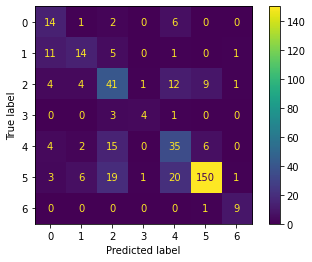

In [8]:
# Model 280x210
model_ = Model_280x210
X = input_data[2]
Y = labels[2]
# X = BLC_test_280x210[0]
# Y = BLC_test_280x210[1]
iter = X.shape[0] // 100
Y_pred = torch.zeros(0)
for i in range(iter+1):
    X_ = X[i*100:(i+1)*100]
    Y_ = model_.forward_noDrop(X_).argmax(dim=1)
    Y_pred = torch.cat([Y_pred,Y_])
results = confusion_matrix(Y,Y_pred)
results

Nr. of Data : 
 3833
Accuracy of The Model : 
 0.7203235063918602


,weights,Precision,Recall_Sensitivity,Specificity,f1_score
0,9.5%,54.0%,84.3%,92.5%,65.9%
1,13.7%,84.0%,55.2%,98.3%,66.6%
2,15.2%,73.8%,50.9%,96.8%,60.2%
3,3.0%,74.8%,97.4%,99.0%,84.6%
4,12.8%,45.3%,85.5%,84.8%,59.2%
5,41.7%,93.0%,74.2%,96.0%,82.5%
6,4.1%,90.3%,95.5%,99.6%,92.8%
Simple Avg.,nan%,73.6%,77.6%,95.3%,73.1%
Weighted Avg.,nan%,78.4%,72.0%,94.9%,72.9%


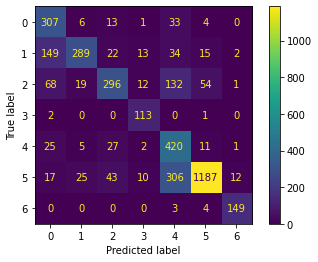

In [9]:
# Model AutoEncoder
model_ = Model_A_En
X = A_E_input_data[0]
Y = A_E_labels[0]
# X = BLC_test_A_E[0]
# Y = BLC_test_A_E[1]
iter = X.shape[0] // 100
Y_pred = torch.zeros(0)
for i in range(iter+1):
    X_ = X[i*100:(i+1)*100]
    Y_ = model_.forward_noDrop(X_).argmax(dim=1)
    Y_pred = torch.cat([Y_pred,Y_])
results = confusion_matrix(Y,Y_pred)
results

**Import Meta Data**

In [10]:
Meta_Data_Augmented = pickle.load(open( G_path + 'Meta_Data_Augmented','rb'))

# **CNN: 280x210, Get CNN OutPut (Soft-Max)**

In [11]:
model_ = Model_280x210
X = torch.cat([input_data[0],input_data[1],input_data[2]],dim=0)
iter = X.shape[0] // 100
Y_pred = torch.zeros(0)
for i in range(iter+1):
    X_ = X[i*100:(i+1)*100]
    Y_ = torch.softmax(model_.forward_noDrop(X_),dim=1)
    Y_pred = torch.cat([Y_pred,Y_])
X.shape , Y_pred.shape

(torch.Size([4647, 3, 280, 210]), torch.Size([4647, 7]))

In [12]:
df_CNN = pd.DataFrame(Y_pred.detach().numpy()).add_prefix('CNN_')
meta_data_key = pd.concat([input_data[3][0],input_data[3][1],input_data[3][2]],axis=0).reset_index(drop=True)
df_CNN = pd.concat([meta_data_key,df_CNN],axis=1).reset_index(drop=True)
CNN_280x210_data = df_CNN.merge(Meta_Data_Augmented.drop(columns=['type']) ,how='left', on='image_id')

In [13]:
CNN_280x210_data[:2]

,type,image_id,CNN_0,CNN_1,CNN_2,CNN_3,CNN_4,CNN_5,CNN_6,lesion_id,dx,dx_type,age,sex,localization,image_label
0,train,ISIC_0032929,0.023862,0.004363,0.720161,0.000374,0.194677,0.056539,0.000025,HAM_0003321,bkl,histo,75.0,female,face,2
1,train,ISIC_0026790,0.000023,0.000322,0.203294,0.000002,0.263729,0.531866,0.000763,HAM_0005779,bkl,consensus,55.0,male,back,2


In [14]:
cols = ['localization','sex','dx_type']
CNN_280x210_data_encoded = pd.get_dummies(CNN_280x210_data, columns= cols).reset_index(drop=True)

In [15]:
def standardizaion(dataset, attr):
    mean = dataset[dataset.type.str.contains('train')][attr].mean()
    std = dataset[dataset.type.str.contains('train')][attr].std()
    dataset[attr] = (dataset[attr] - mean ) / std
    return dataset
CNN_280x210_data_encoded_STD = standardizaion(CNN_280x210_data_encoded,'age')

In [ ]:
pickle.dump(CNN_280x210_data_encoded_STD, open(G_path + '/CNN_Output/'+ 'CNN_280x210_Ouput', 'wb'))

# **CNN: AutoEncoder, Get CNN OutPut (Soft-Max)**

In [13]:
model_ = Model_A_En
Y_pred = torch.zeros(0)
# X = torch.cat([A_E_input_data[0],A_E_input_data[1],A_E_input_data[2]],dim=0)
for X in [A_E_input_data[0],A_E_input_data[1],A_E_input_data[2]]:
    iter = X.shape[0] // 100
    for i in range(iter+1):
        X_ = X[i*100:(i+1)*100]
        # print('iter: ',i)
        # print(X.shape , Y_pred.shape)
        Y_ = model_.forward_noDrop(X_)
        Y_pred = torch.cat([Y_pred,Y_])
X.shape , Y_pred.shape 

: 

: 

In [ ]:
Y_soft = torch.softmax(Y_pred, dim=1)

In [59]:
df_CNN = pd.DataFrame(Y_pred.detach().numpy()).add_prefix('CNN_')
meta_data_key = pd.concat([input_data[3][0],input_data[3][1],input_data[3][2]],axis=0).reset_index(drop=True)
df_CNN = pd.concat([meta_data_key,df_CNN],axis=1).reset_index(drop=True)
CNN_280x210_data = df_CNN.merge(Meta_Data_Augmented.drop(columns=['type','Unnamed: 0','age_mdf']) ,how='left', on='image_id')

In [14]:
datasource = pd.concat([train_data,valid_data, test_data], axis=0).reset_index(drop=True)

In [15]:
#Train data standardization
datasource_std = np.stack(datasource['img_array'].values) / 255
for i in range(0,datasource_std.shape[0]):
    datasource_std[i] = (datasource_std[i] - Mean) / STD

datasource_std_T = torch.tensor(datasource_std, dtype= torch.float32).transpose(3,1)



In [22]:
model_ = Model_1.model.eval()
datasource_CNN_out = model_(datasource_std_T)
datasource_CNN_soft = torch.softmax(datasource_CNN_out,dim=1)
df_CNN = pd.DataFrame(datasource_CNN_soft.detach().numpy()).add_prefix('CNN_')
datasource_v2 = pd.concat([datasource,df_CNN],axis=1).reset_index(drop=True)

**One-Hot Encoding**

In [26]:
cols = ['localization','sex','dx_type']
datasource_v2_OneHot = pd.get_dummies(datasource_v2, columns= cols).reset_index(drop=True)

In [27]:
datasource_v2_OneHot.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4510 entries, 0 to 4509
Data columns (total 33 columns):
 #   Column                        Non-Null Count  Dtype   
---  ------                        --------------  -----   
 0   image_id                      4510 non-null   object  
 1   img_array                     4510 non-null   object  
 2   lesion_id                     4510 non-null   object  
 3   image_label                   4510 non-null   category
 4   age                           4510 non-null   float64 
 5   label_id                      4510 non-null   int8    
 6   type                          4510 non-null   object  
 7   CNN_0                         4510 non-null   float32 
 8   CNN_1                         4510 non-null   float32 
 9   CNN_2                         4510 non-null   float32 
 10  CNN_3                         4510 non-null   float32 
 11  CNN_4                         4510 non-null   float32 
 12  CNN_5                         4510 non-null   fl

In [28]:
pd.to_pickle(datasource_v2_OneHot, path+'DataSource_60x45_OneHot_CNN.pickle')

In [ ]:
datasource_v2_OneHot.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4510 entries, 0 to 4509
Data columns (total 33 columns):
 #   Column                        Non-Null Count  Dtype   
---  ------                        --------------  -----   
 0   image_id                      4510 non-null   object  
 1   img_array                     4510 non-null   object  
 2   lesion_id                     4510 non-null   object  
 3   image_label                   4510 non-null   category
 4   age                           4510 non-null   float64 
 5   label_id                      4510 non-null   int8    
 6   type                          4510 non-null   object  
 7   CNN_0                         4510 non-null   float32 
 8   CNN_1                         4510 non-null   float32 
 9   CNN_2                         4510 non-null   float32 
 10  CNN_3                         4510 non-null   float32 
 11  CNN_4                         4510 non-null   float32 
 12  CNN_5                         4510 non-null   fl

**Ordinal Encoding**

In [31]:
ord_enc = sk.preprocessing.OrdinalEncoder()
datasource_v3_Ord = datasource_v2
datasource_v3_Ord['sex'] = ord_enc.fit_transform(datasource_v3_Ord[['sex']])
datasource_v3_Ord['localization'] = ord_enc.fit_transform(datasource_v3_Ord[['localization']])
datasource_v3_Ord['dx_type'] = ord_enc.fit_transform(datasource_v3_Ord[['dx_type']])
datasource_v3_Ord.reset_index(drop=True, inplace=True)

In [29]:
def MinMaxScaling(dataset, attr):
    min = dataset[dataset.type.str.contains('train|valid')][attr].min()
    max = dataset[dataset.type.str.contains('train|valid')][attr].max()
    dataset[attr] = (dataset[attr] - min ) / (max-min)
    return dataset

In [36]:
datasource_v3_Ord_Norm = datasource_v3_Ord.copy()
datasource_v3_Ord_Norm = MinMaxScaling(datasource_v3_Ord_Norm , 'localization')
datasource_v3_Ord_Norm = MinMaxScaling(datasource_v3_Ord_Norm , 'dx_type')

In [ ]:
pd.to_pickle(datasource_v3_Ord, path+'DataSource_60x45_Ordinal_CNN.pickle' )